In [1]:
%%bash
[[ ! -e /content/sample_data ]] && exit  ## run this cell only in colab
 
pip install optax -qqq
pip install networkx==2.5 -qqq
pip install netgraph
git clone https://github.com/ramithuh/differentiable-trees --quiet

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

if(os.path.exists('/content/sample_data')):
  sys.path.append('differentiable-trees/')

import jax.numpy as jnp
import jax.nn as nn
import jax
import optax
import functools

import pydot
import numpy as np
from helpers import *

from matplotlib import rc
rc('animation', html='jshtml')

In [3]:
key = jax.random.PRNGKey(42)

## Sequences

In [4]:
# sequences (fixed)
n_leaves    = 4
n_ancestors = n_leaves - 1

seq_length = 10

n_all = n_leaves + n_ancestors


blank = jnp.array([0,0,0,0])

In [5]:
# similarity matrix (fixed)
sm = jnp.array([[0,1],
               [1,0]])

In [6]:
seqs = jax.random.randint(key, shape = (n_all, seq_length), minval = 0, maxval = 2)

In [7]:
base_tree = jnp.zeros((n_all, n_all))

In [8]:
seqs

DeviceArray([[1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
             [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
             [0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
             [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
             [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
             [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

## Tree Topology (also parameterized)

### initialize parameters

In [9]:
optimizer = optax.adam(1)

params = {'t': jax.random.normal(key, (n_all - 1,n_ancestors))}


for i in range(0, n_ancestors):
    params[chr(97+i + n_leaves)] = jax.random.normal(key, (seq_length,))
    

opt_state = optimizer.init(params)

In [10]:
params.keys()

dict_keys(['t', 'e', 'f', 'g'])

In [11]:
# t_q = jnp.argmax(t_softmax,axis = 1).T

In [12]:
base_tree.shape

(7, 7)

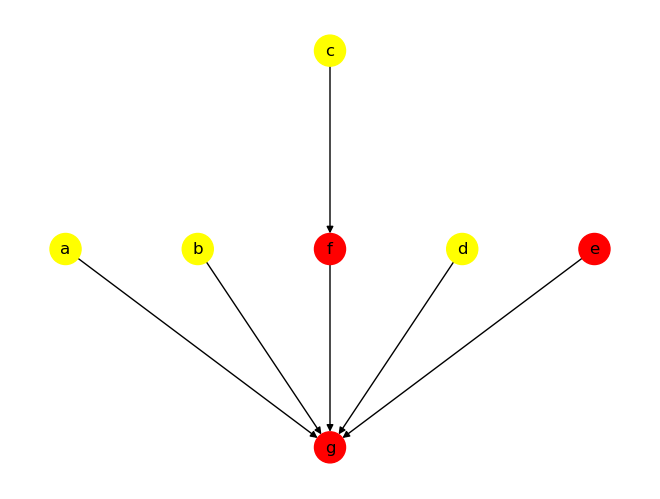

In [13]:
show_graph_with_labels(discretize_tree_topology(update_tree(params, base_tree), n_all),n_leaves)

### Function to compute total distance

In [14]:
def compute_cost(sequences, tree, verbose = False, average = True):
    if(verbose==True):
        show_graph_with_labels(discretize_tree_topology(tree, n_all),n_leaves)
        
    selection = jnp.matmul(tree,sequences)
    # print(selection)
    
#     #method 1: (downside needs integers as we are indexing)
#     selection = selection.astype(int)
#     ans = sm[selection,sequences].sum()
    
    #method 2:
    if(average):
        ans = abs(selection - sequences).sum() ## works currently as sm is the basic config. need to think about extending
    else:
        ans = jnp.sum(abs(selection - sequences), axis = 1)
    
    return ans

In [15]:
update_tree(params, base_tree)

DeviceArray([[0.        , 0.        , 0.        , 0.        , 0.30321804,
              0.16727467, 0.5295073 ],
             [0.        , 0.        , 0.        , 0.        , 0.3965519 ,
              0.12775946, 0.4756886 ],
             [0.        , 0.        , 0.        , 0.        , 0.12712821,
              0.8479232 , 0.02494855],
             [0.        , 0.        , 0.        , 0.        , 0.31710118,
              0.2897718 , 0.39312702],
             [0.        , 0.        , 0.        , 0.        , 0.20008957,
              0.17309996, 0.62681043],
             [0.        , 0.        , 0.        , 0.        , 0.14293277,
              0.3836567 , 0.47341058],
             [0.        , 0.        , 0.        , 0.        , 0.        ,
              0.        , 1.        ]], dtype=float32)

DeviceArray(23.855356, dtype=float32)

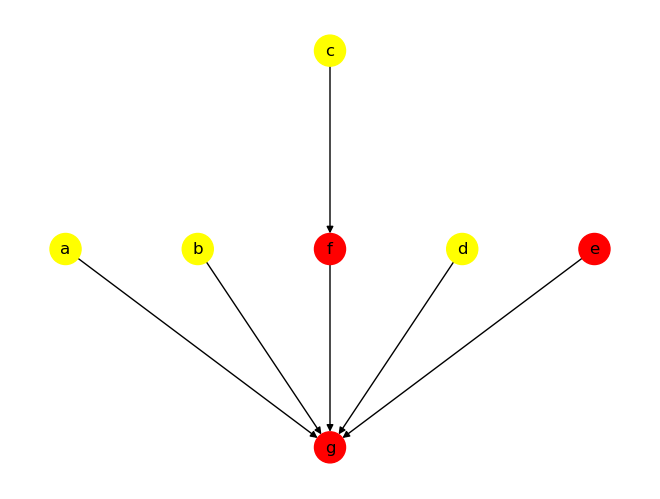

In [16]:
compute_cost(seqs,update_tree(params, base_tree),1)

In [17]:
params

{'t': DeviceArray([[-0.63462436, -1.2294393 , -0.07712954],
              [-0.22857422, -1.3612318 , -0.04661765],
              [-0.14380704,  1.7537868 , -1.7721876 ],
              [ 0.18559739,  0.09547025,  0.40050933],
              [ 0.9773695 ,  0.83247375,  2.1192486 ],
              [-0.67893344,  0.3084403 ,  0.51865524]], dtype=float32),
 'e': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32),
 'f': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32),
 'g': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32)}

In [18]:
n_all

7

In [19]:
# tree_force_loss = 0 

# t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

# for k in range(n_all - 1, n_all - 1 - n_ancestors, -1):
#     tree_force_loss += (abs(t_new[:-1,k].sum()-2))**2

# print(tree_force_loss)

In [20]:
def regularize_graph(t_, s, verbose = False):
    
    tree_force_loss = jnp.sum(jnp.power(s*jnp.abs(jnp.sum(t_[:-1, n_all - n_ancestors: n_all], axis = 0) - 2),2))
    
    #tree_force_loss = (s*abs(t_[:-1,-2].sum()-2))**2 + (s*abs(t_[:-1,-1].sum()-2))**2
    
    loop_loss = jnp.multiply(jnp.identity(n_all-1), t_[:-1,:-1]).sum()*100  ## penalize self connections
    
    
    if(verbose):
        print("bifurcating tree_forcing_loss = ", tree_force_loss)
        print("self loop_loss = ", loop_loss)
    
    return tree_force_loss + loop_loss

In [21]:
def compute_loss(params, seqs, base_tree, verbose = False):
    seqs_ = combine_to_seq(params, seqs, n_leaves, n_all)
    t_    = update_tree(params, base_tree)

    loss  = compute_cost(seqs_,t_) + regularize_graph(t_,10, verbose)
    
    return loss

In [22]:
compute_loss(params, seqs, base_tree)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


DeviceArray(130.08109, dtype=float32)

In [23]:
trees = []

for _ in range(1500):
    grads = jax.grad(compute_loss)(params, seqs, base_tree)
    
    
    t_= update_tree(params, base_tree)
    t__ = discretize_tree_topology(t_,n_all)
    t__ = t__.at[-1,-1].set(0)
    
    trees.append(t__)
    
    if(_%100==0):
        # temp  = combine_to_seq(params, seqs)
        
        print("{:.5f}".format(compute_loss(params, seqs, base_tree)),end = " seq = {}\n")
        #print(t_[:,-2],",",t_[:,-1],end="}\n")
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


130.08109 seq = {}
20.99968 seq = {}
20.99238 seq = {}
20.98862 seq = {}
20.98308 seq = {}
20.97110 seq = {}
20.92741 seq = {}
17.83709 seq = {}
17.03249 seq = {}
17.01831 seq = {}
17.01234 seq = {}
17.00904 seq = {}
17.00696 seq = {}
17.00553 seq = {}
17.00449 seq = {}


In [24]:
adjacency_matrix2 = jnp.array(trees)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/envs/pytorch/lib/python3.9/site-packages/netgraph/_utils.py:395: RuntimeWarning: invalid value encountered in divide
  unit_vector = vector / np.linalg.norm(vector)


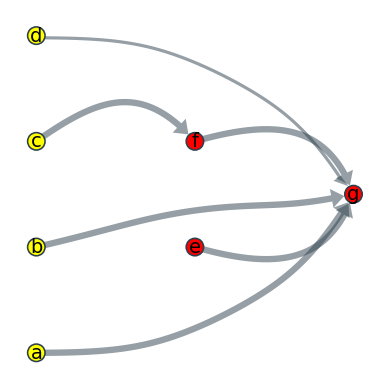

In [25]:
anim = animate_tree(adjacency_matrix2, n_leaves, n_ancestors, total_frames = 500 )

In [26]:
anim.save(f"nodes_{n_all}.mp4")

In [27]:
t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

In [28]:
discretized = jnp.round(combine_to_seq(params, seqs, n_leaves, n_all))

/opt/conda/envs/pytorch/lib/python3.9/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [29]:
compute_loss(params, seqs, base_tree, 1)

bifurcating tree_forcing_loss =  0.00048639788
self loop_loss =  0.00045291122


DeviceArray(17.0037, dtype=float32)

In [30]:
t_new

DeviceArray([[0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

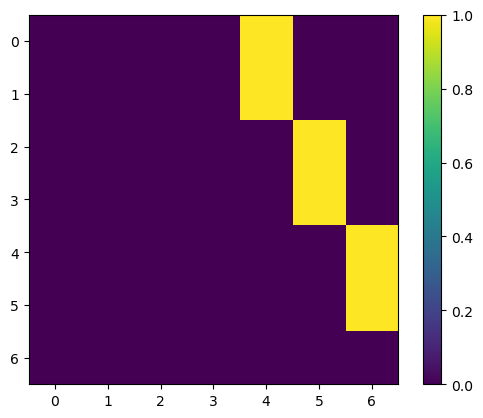

In [31]:
plt.imshow(adjacency_matrix2[300])
plt.colorbar()

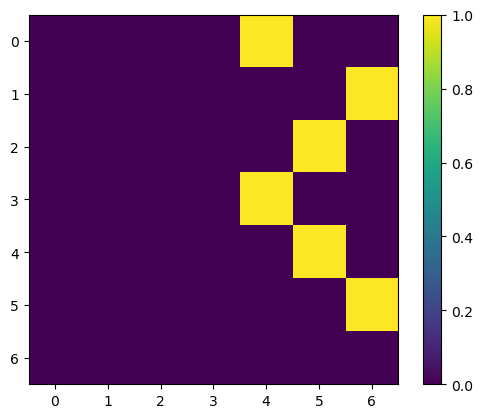

In [32]:
plt.imshow(adjacency_matrix2[-1])
plt.colorbar()


## Retrieving the new sequences array

In [33]:
t_new = discretize_tree_topology(update_tree(params, base_tree), n_leaves + n_ancestors)

In [ ]:
combine_to_seq(params, seqs, n_leaves, n_all)

DeviceArray([[1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
             [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
             [0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [51]:
discretized = jnp.round(combine_to_seq(params, seqs, n_leaves, n_all))

In [52]:
discretized

DeviceArray([[1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
             [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
             [0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [43]:
seqs

DeviceArray([[1, 1, 1, 0, 0, 1, 0, 1, 0, 1],
             [1, 1, 1, 1, 1, 1, 0, 1, 0, 0],
             [0, 0, 1, 1, 0, 1, 0, 1, 0, 0],
             [1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
             [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 0, 0, 1, 1, 1, 1, 1, 0],
             [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [44]:
params

{'e': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32),
 'f': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32),
 'g': DeviceArray([ 0.36900434, -0.46067542, -0.8650934 ,  1.2080883 ,
               1.003065  , -0.8708058 , -0.3984997 , -0.6670092 ,
               0.33689356,  0.39822492], dtype=float32),
 't': DeviceArray([[ 4.8393407, -2.064851 , -3.3221097],
              [-1.2665508, -3.1345305,  6.0019083],
              [-2.5783327,  5.0026674, -7.6835756],
              [ 5.429791 , -1.028855 , -3.887567 ],
              [-4.0181875,  8.340082 ,  1.2095973],
              [-3.9840841, -8.726715 ,  6.522282 ]], dtype=float32)}

### New cost

In [36]:
t_new

DeviceArray([[0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

DeviceArray(17., dtype=float32)

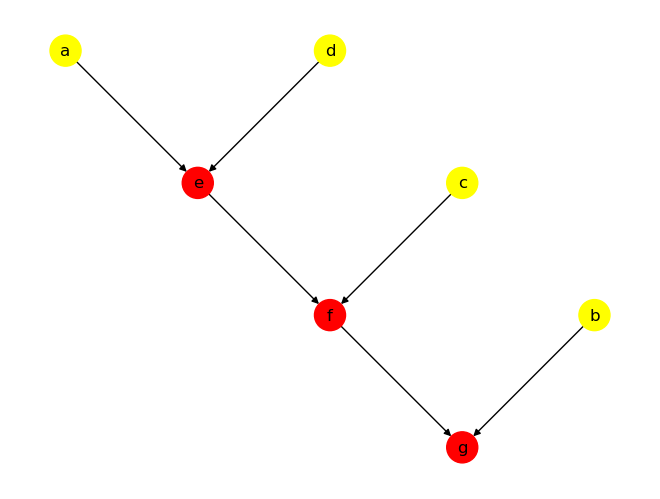

In [37]:
compute_cost(discretized, t_new, 1)

In [38]:
t_new

DeviceArray([[0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 1., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0.],
             [0., 0., 0., 0., 0., 0., 1.],
             [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

### Old cost

In [39]:
compute_cost(seqs, base_tree) ##when d & e were all zeros

DeviceArray(38., dtype=float32)

### test arbitrary sequence for d & e

In [40]:
test = jnp.array([[0, 0., 0., 0.],
                 [1., 0., 0., 1.],
                 [0., 1., 1., 0.],
                 [0., 0., 0., 0.],
                 [0., 0., 0., 0.]])

In [41]:
# compute_cost(test, t_new)